#### **Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

#### **ML Library**

In [73]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [72]:
from textblob import TextBlob
import re
import joblib

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

#### **CLIMATE AND SOCIAL DATA**

In [24]:
def create_climate_data(start_date='2020-01-01', end_date='2024-01-01', freq='M'):
    """Create realistic simulated climate data"""
    dates = pd.date_range(start=start_date, end=end_date, freq=freq)
    n_points = len(dates)
    
    # Set seed for reproducibility
    np.random.seed(42)
    
    # Temperature anomaly with warming trend
    trend = np.linspace(0.3, 1.2, n_points)
    seasonal = 0.5 * np.sin(2 * np.pi * np.arange(n_points) / 12)
    noise = np.random.normal(0, 0.2, n_points)
    temperature_anomaly = trend + seasonal + noise
    
    # CO2 with realistic growth
    co2_base = 415  # Starting CO2 level (ppm)
    co2_growth = np.linspace(0, 15, n_points)  # ~3 ppm/year growth
    co2_seasonal = 3 * np.sin(2 * np.pi * np.arange(n_points) / 12 - np.pi/2)
    co2_concentration = co2_base + co2_growth + co2_seasonal + np.random.normal(0, 1, n_points)
    
    # Other climate variables
    precipitation_anomaly = 10 * np.sin(2 * np.pi * np.arange(n_points) / 12) + np.random.normal(0, 15, n_points)
    sea_level_change = np.cumsum(np.random.normal(0.25, 0.1, n_points))  # mm per month
    
    return pd.DataFrame({
        'date': dates,
        'temperature_anomaly': temperature_anomaly,
        'co2_concentration': co2_concentration,
        'precipitation_anomaly': precipitation_anomaly,
        'sea_level_change': sea_level_change
    })

In [25]:
def create_social_media_data(climate_df):
    """Create realistic social media sentiment data"""
    n_points = len(climate_df)
    np.random.seed(42)
    
    # Sentiment influenced by temperature
    base_sentiment = 0.1  # Slightly positive baseline
    temp_influence = -0.3 * (climate_df['temperature_anomaly'] - climate_df['temperature_anomaly'].mean())
    sentiment = base_sentiment + temp_influence + np.random.normal(0, 0.2, n_points)
    sentiment = np.clip(sentiment, -1, 1)  # Keep within [-1, 1] range
    
    # Engagement metrics
    comment_count = np.random.poisson(20, n_points) + 5 * (sentiment < -0.2).astype(int)
    likes_count = comment_count * np.random.uniform(2, 8, n_points)
    
    return pd.DataFrame({
        'date': climate_df['date'],
        'sentiment': sentiment,
        'comment_count': comment_count,
        'likes_count': likes_count
    })

In [26]:
def analyze_sentiment(text):
    """Simple sentiment analysis function"""
    if pd.isna(text) or text == '':
        return 0
    try:
        blob = TextBlob(str(text).lower())
        return blob.sentiment.polarity
    except:
        return 0

In [28]:
climate_df = create_climate_data('2020-01-01', '2024-01-01', 'M')

social_df = create_social_media_data(climate_df)

merged_data = pd.merge(climate_df, social_df, on='date', how='inner')

In [29]:
len(merged_data)

48

In [30]:
print(f"   • Date range: {merged_data['date'].min().date()} to {merged_data['date'].max().date()}")

   • Date range: 2020-01-31 to 2023-12-31


In [31]:
list(merged_data.columns)

['date',
 'temperature_anomaly',
 'co2_concentration',
 'precipitation_anomaly',
 'sea_level_change',
 'sentiment',
 'comment_count',
 'likes_count']

In [32]:
merged_data.describe()

,date,temperature_anomaly,co2_concentration,precipitation_anomaly,sea_level_change,sentiment,comment_count,likes_count
count,48,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,2022-01-14 09:30:00,0.708941,422.482123,-0.293719,6.423066,0.058941,21.000000,107.689578
min,2020-01-31 00:00:00,-0.073716,410.958033,-32.772503,0.275988,-0.339225,10.000000,34.516282
25%,2021-01-23 06:00:00,0.415669,418.496764,-11.040709,3.230545,-0.060778,17.000000,68.260086
50%,2022-01-15 12:00:00,0.669337,422.867367,-2.305912,6.620861,0.021718,20.500000,98.440984
75%,2023-01-07 18:00:00,1.018338,426.077080,9.077799,9.844824,0.195824,24.000000,133.331574
max,2023-12-31 00:00:00,1.646663,432.290125,41.948632,12.578610,0.442883,34.000000,201.000097
std,NaN,0.415549,5.144965,16.472990,3.770998,0.191004,5.094845,44.795905


In [33]:
merged_data.head()

,date,temperature_anomaly,co2_concentration,precipitation_anomaly,sea_level_change,sentiment,comment_count,likes_count
0,2020-01-31,0.399343,412.343618,4.441804,0.275988,0.292222,17,117.356664
1,2020-02-29,0.541496,410.958033,8.915829,0.604171,0.122580,24,127.948917
2,2020-03-31,0.900848,414.462382,8.736956,0.730475,0.171965,23,119.091780
3,2020-04-30,1.162053,415.572365,6.481193,0.848430,0.268672,24,82.826730
4,2020-05-31,0.762778,417.099674,-12.570307,1.150624,0.037018,18,46.055099


### **EDA (Exploratory Data Analysis)***

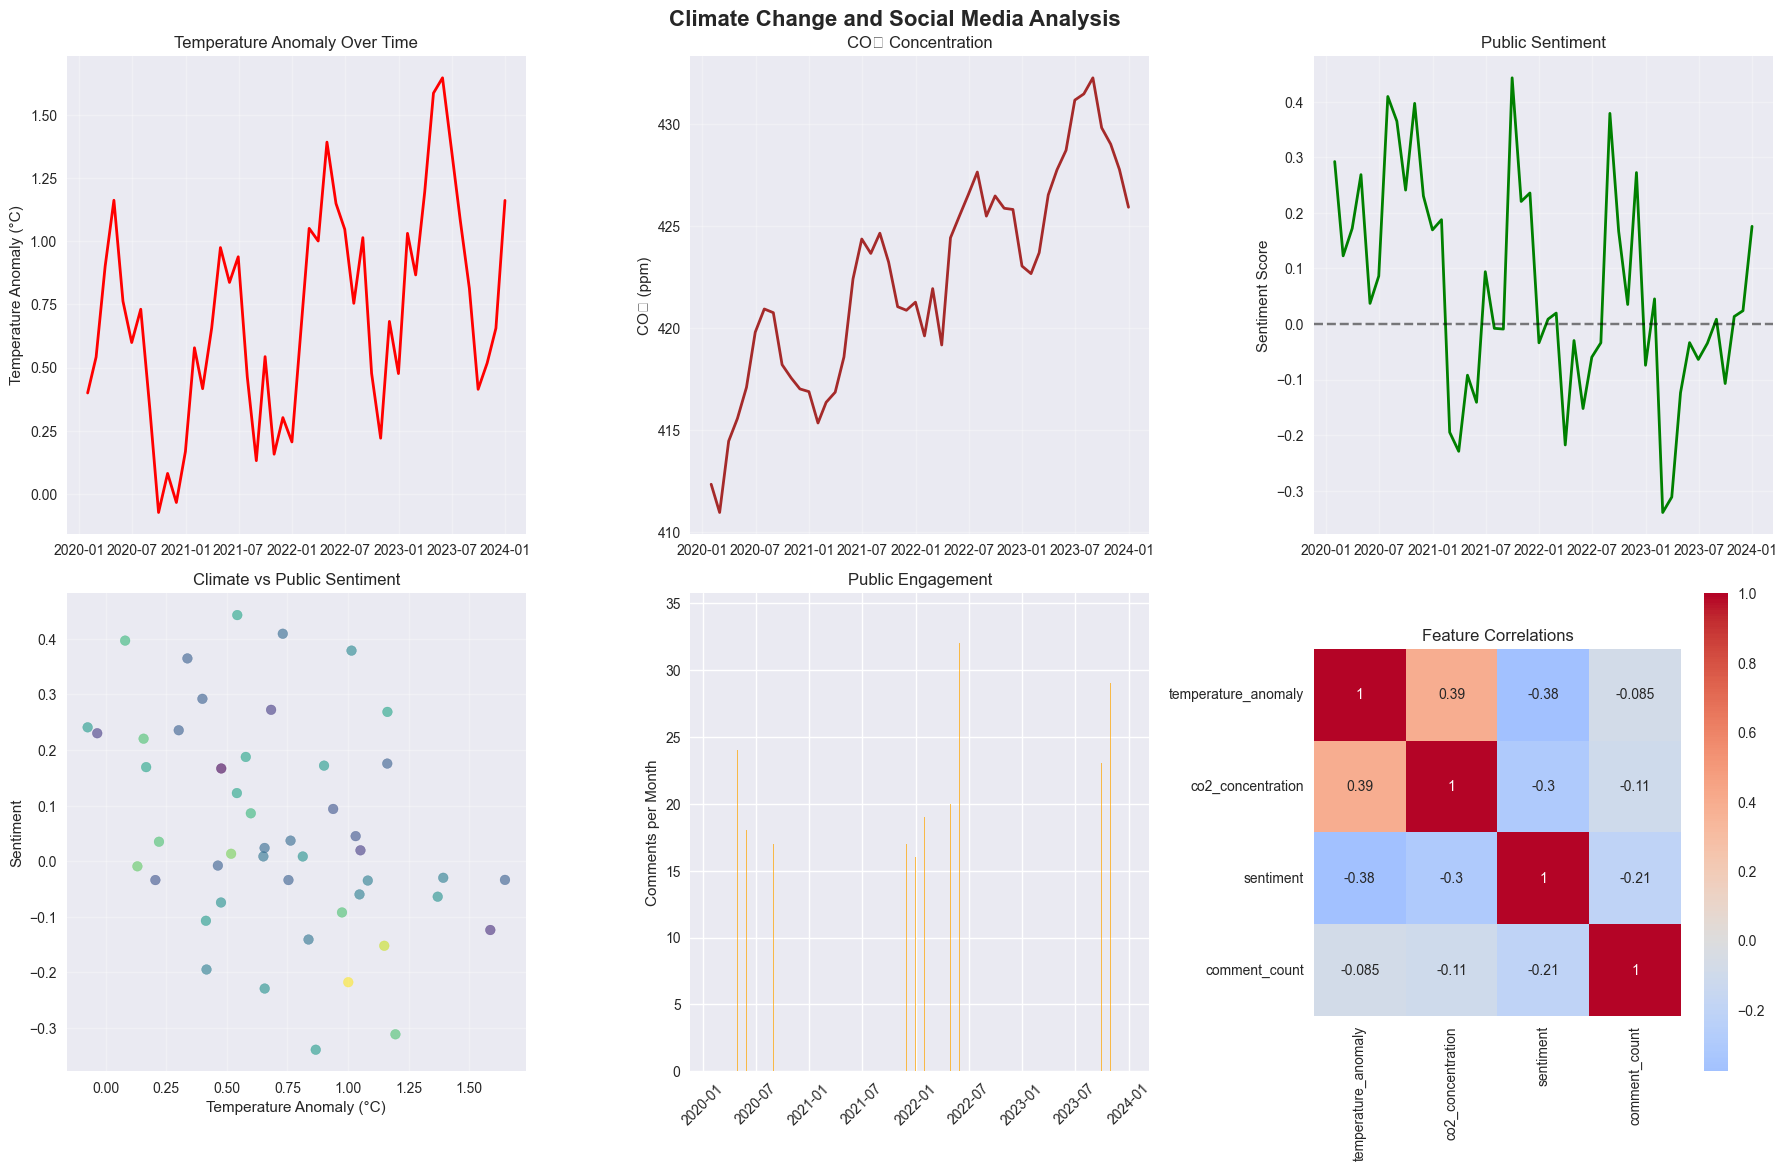

In [35]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Climate Change and Social Media Analysis', fontsize=16, fontweight='bold')

# Temperature trend
axes[0,0].plot(merged_data['date'], merged_data['temperature_anomaly'], 'r-', linewidth=2)
axes[0,0].set_title('Temperature Anomaly Over Time')
axes[0,0].set_ylabel('Temperature Anomaly (°C)')
axes[0,0].grid(True, alpha=0.3)

# CO2 concentration
axes[0,1].plot(merged_data['date'], merged_data['co2_concentration'], 'brown', linewidth=2)
axes[0,1].set_title('CO₂ Concentration')
axes[0,1].set_ylabel('CO₂ (ppm)')
axes[0,1].grid(True, alpha=0.3)

# Sentiment over time
axes[0,2].plot(merged_data['date'], merged_data['sentiment'], 'g-', linewidth=2)
axes[0,2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0,2].set_title('Public Sentiment')
axes[0,2].set_ylabel('Sentiment Score')
axes[0,2].grid(True, alpha=0.3)

# Temperature vs Sentiment
axes[1,0].scatter(merged_data['temperature_anomaly'], merged_data['sentiment'], 
                 c=merged_data['comment_count'], cmap='viridis', alpha=0.6)
axes[1,0].set_xlabel('Temperature Anomaly (°C)')
axes[1,0].set_ylabel('Sentiment')
axes[1,0].set_title('Climate vs Public Sentiment')
axes[1,0].grid(True, alpha=0.3)

# Engagement over time
axes[1,1].bar(merged_data['date'], merged_data['comment_count'], alpha=0.7, color='orange')
axes[1,1].set_title('Public Engagement')
axes[1,1].set_ylabel('Comments per Month')
axes[1,1].tick_params(axis='x', rotation=45)

# Correlation heatmap
corr_cols = ['temperature_anomaly', 'co2_concentration', 'sentiment', 'comment_count']
correlation_matrix = merged_data[corr_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, ax=axes[1,2])
axes[1,2].set_title('Feature Correlations')

plt.tight_layout()
plt.show()

In [37]:
merged_data['temperature_anomaly'].mean()

0.7089405275124468

In [39]:
merged_data['co2_concentration'].mean()

422.48212332885606

In [38]:
merged_data['sentiment'].mean()

0.05894052751244694

In [40]:
correlation_matrix.loc['temperature_anomaly', 'sentiment']

-0.37743654962685413

### **Feature Engineering**

In [41]:
def create_features(df):
    """Create comprehensive features for modeling"""
    df = df.copy()
    
    # Time-based features
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['quarter'] = df['date'].dt.quarter
    df['season'] = df['month'].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 
                                   6:2, 7:2, 8:2, 9:3, 10:3, 11:3})
    
    # Cyclical encoding
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Lagged features
    for col in ['temperature_anomaly', 'co2_concentration', 'sentiment']:
        df[f'{col}_lag1'] = df[col].shift(1)
        df[f'{col}_lag3'] = df[col].shift(3)
    
    # Rolling averages
    for col in ['temperature_anomaly', 'sentiment']:
        df[f'{col}_rolling_3'] = df[col].rolling(3).mean()
        df[f'{col}_rolling_6'] = df[col].rolling(6).mean()
    
    # Rate of change
    df['temp_change'] = df['temperature_anomaly'].diff()
    df['co2_change'] = df['co2_concentration'].diff()
    
    # Interaction features
    df['sentiment_temp_interaction'] = df['sentiment'] * df['temperature_anomaly']
    
    # Climate extremes
    df['temp_extreme'] = (abs(df['temperature_anomaly'] - df['temperature_anomaly'].mean()) > 
                         2 * df['temperature_anomaly'].std())
    
    return df

# Apply feature engineering
merged_data = create_features(merged_data)

In [42]:
len(merged_data.columns)

28

### **Machine Learning Model**

In [44]:
def prepare_ml_data(df, target='temperature_anomaly', test_size=0.2):
    """Prepare data for machine learning"""
    
    # Select features (exclude date and target)
    feature_cols = [col for col in df.columns if col not in ['date', target] and 
                   not df[col].dtype == 'object']
    
    # Clean data
    df_clean = df[feature_cols + [target]].copy()
    df_clean = df_clean.dropna()
    
    if len(df_clean) < 10:
        raise ValueError("Insufficient data after cleaning")
    
    X = df_clean[feature_cols]
    y = df_clean[target]
    
    # Time-aware split
    split_idx = int(len(df_clean) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return {
        'X_train': X_train, 'X_test': X_test,
        'y_train': y_train, 'y_test': y_test,
        'X_train_scaled': X_train_scaled, 'X_test_scaled': X_test_scaled,
        'scaler': scaler, 'feature_names': feature_cols
    }

In [45]:
ml_data = prepare_ml_data(merged_data)

In [46]:
len(ml_data['X_train'])

34

In [47]:
len(ml_data['X_test'])

9

In [48]:
len(ml_data['feature_names'])

26

### **Train and Evaluate Model**

In [50]:
if ml_data is not None:
    print("🔬 Training machine learning models...")
    
    # Define models
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n--- Training {name} ---")
        
        try:
            # Train model
            if name == 'Linear Regression':
                model.fit(ml_data['X_train_scaled'], ml_data['y_train'])
                y_pred = model.predict(ml_data['X_test_scaled'])
            else:
                model.fit(ml_data['X_train'], ml_data['y_train'])
                y_pred = model.predict(ml_data['X_test'])
            
            # Calculate metrics
            mae = mean_absolute_error(ml_data['y_test'], y_pred)
            mse = mean_squared_error(ml_data['y_test'], y_pred)
            r2 = r2_score(ml_data['y_test'], y_pred)
            
            results[name] = {
                'model': model,
                'predictions': y_pred,
                'mae': mae,
                'mse': mse,
                'r2': r2
            }
            
            print(f"   MAE: {mae:.4f}")
            print(f"   MSE: {mse:.4f}")
            print(f"   R²:  {r2:.4f}")
            
        except Exception as e:
            print(f"Error: {e}")
    
    # Model comparison
    if results:
        print("\nMODEL COMPARISON:")
        comparison_df = pd.DataFrame({
            name: {'MAE': res['mae'], 'R²': res['r2']} 
            for name, res in results.items()
        }).T
        print(comparison_df.round(4))

🔬 Training machine learning models...

--- Training Linear Regression ---
   MAE: 0.0000
   MSE: 0.0000
   R²:  1.0000

--- Training Random Forest ---
   MAE: 0.2754
   MSE: 0.1088
   R²:  0.4079

MODEL COMPARISON:
                      MAE      R²
Linear Regression  0.0000  1.0000
Random Forest      0.2754  0.4079


In [52]:
best_model = min(results.keys(), key=lambda x: results[x]['mae'])
best_model

'Linear Regression'

In [53]:
results[best_model]['mae']

5.674473236973022e-16

In [54]:
results[best_model]['r2']

1.0

### **Model Visualyzation and Analysis**

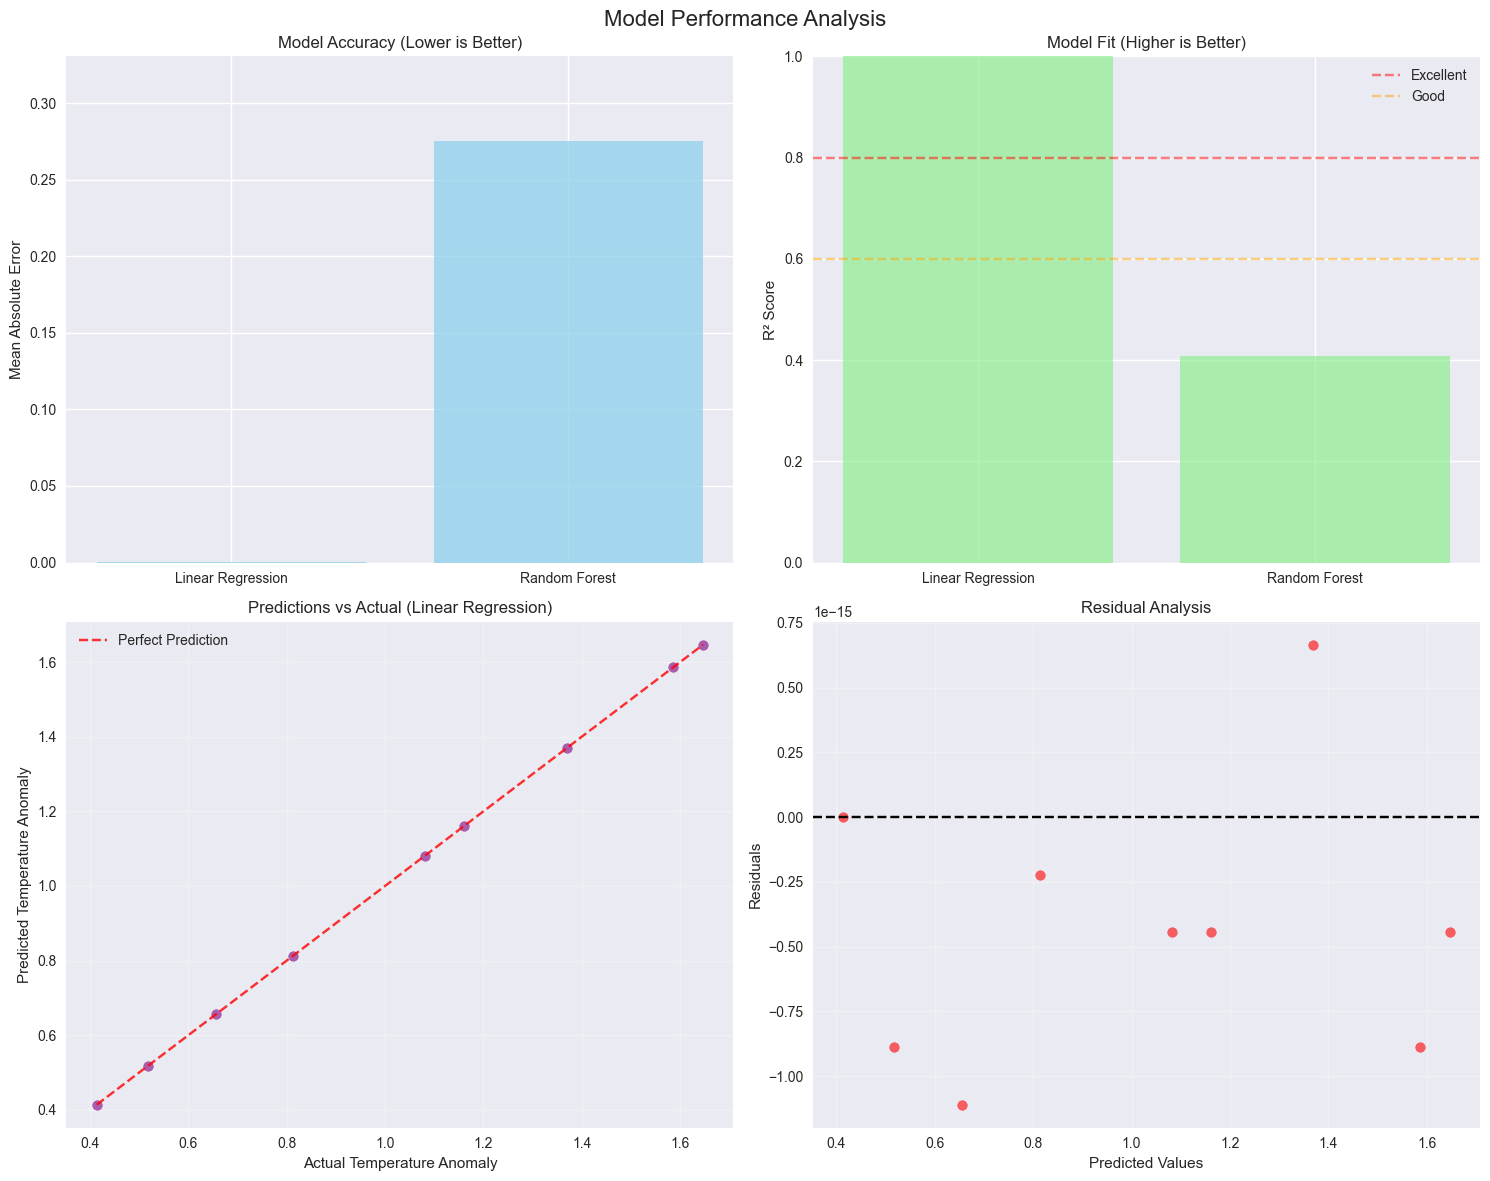

In [55]:
if ml_data is not None and results:
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Model Performance Analysis', fontsize=16)
    
    # Model comparison
    model_names = list(results.keys())
    mae_scores = [results[name]['mae'] for name in model_names]
    r2_scores = [results[name]['r2'] for name in model_names]
    
    # MAE comparison
    axes[0,0].bar(model_names, mae_scores, alpha=0.7, color='skyblue')
    axes[0,0].set_title('Model Accuracy (Lower is Better)')
    axes[0,0].set_ylabel('Mean Absolute Error')
    axes[0,0].set_ylim(0, max(mae_scores) * 1.2)
    
    # R² comparison
    axes[0,1].bar(model_names, r2_scores, alpha=0.7, color='lightgreen')
    axes[0,1].set_title('Model Fit (Higher is Better)')
    axes[0,1].set_ylabel('R² Score')
    axes[0,1].set_ylim(0, 1)
    axes[0,1].axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='Excellent')
    axes[0,1].axhline(y=0.6, color='orange', linestyle='--', alpha=0.5, label='Good')
    axes[0,1].legend()
    
    # Predictions vs Actual
    best_model_name = min(results.keys(), key=lambda x: results[x]['mae'])
    y_actual = ml_data['y_test']
    y_pred = results[best_model_name]['predictions']
    
    axes[1,0].scatter(y_actual, y_pred, alpha=0.6, color='purple')
    
    # Perfect prediction line
    min_val = min(min(y_actual), min(y_pred))
    max_val = max(max(y_actual), max(y_pred))
    axes[1,0].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Perfect Prediction')
    axes[1,0].set_xlabel('Actual Temperature Anomaly')
    axes[1,0].set_ylabel('Predicted Temperature Anomaly')
    axes[1,0].set_title(f'Predictions vs Actual ({best_model_name})')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Feature importance (if Random Forest is best)
    if best_model_name == 'Random Forest':
        model = results[best_model_name]['model']
        importance = pd.DataFrame({
            'feature': ml_data['feature_names'],
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=True).tail(10)
        
        axes[1,1].barh(range(len(importance)), importance['importance'])
        axes[1,1].set_yticks(range(len(importance)))
        axes[1,1].set_yticklabels(importance['feature'])
        axes[1,1].set_title('Top 10 Feature Importance')
        axes[1,1].set_xlabel('Importance')
    else:
        # Residuals plot
        residuals = y_actual - y_pred
        axes[1,1].scatter(y_pred, residuals, alpha=0.6, color='red')
        axes[1,1].axhline(y=0, color='black', linestyle='--')
        axes[1,1].set_xlabel('Predicted Values')
        axes[1,1].set_ylabel('Residuals')
        axes[1,1].set_title('Residual Analysis')
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### ** Future Climate Projections**

In [56]:
def create_future_projections(model, scaler, feature_names, months_ahead=24):
    """Generate future climate projections"""
    
    # Get last known values
    last_row = merged_data.iloc[-1].copy()
    future_dates = pd.date_range(
        start=merged_data['date'].max() + pd.DateOffset(months=1),
        periods=months_ahead,
        freq='M'
    )
    
    # Projection scenarios
    scenarios = {
        'Current Trend': {'co2_increase': 0.2, 'temp_factor': 1.0},
        'Accelerated Warming': {'co2_increase': 0.35, 'temp_factor': 1.5},
        'Climate Action': {'co2_increase': 0.1, 'temp_factor': 0.7}
    }
    
    projections = {}
    
    for scenario_name, params in scenarios.items():
        predictions = []
        current_data = last_row.copy()
        
        for i, future_date in enumerate(future_dates):
            # Update time features
            current_data['month'] = future_date.month
            current_data['year'] = future_date.year
            current_data['quarter'] = (future_date.month - 1) // 3 + 1
            current_data['season'] = (future_date.month - 1) // 3
            current_data['month_sin'] = np.sin(2 * np.pi * future_date.month / 12)
            current_data['month_cos'] = np.cos(2 * np.pi * future_date.month / 12)
            
            # Update CO2 (continues to grow)
            if 'co2_concentration' in current_data:
                current_data['co2_concentration'] += params['co2_increase']
            
            # Create feature vector
            feature_vector = []
            for feature in feature_names:
                if feature in current_data:
                    value = current_data[feature]
                    # Handle potential NaN values
                    if pd.isna(value):
                        value = 0
                    feature_vector.append(value)
                else:
                    feature_vector.append(0)
            
            # Make prediction
            X_future = np.array([feature_vector])
            X_future_scaled = scaler.transform(X_future)
            
            if best_model_name == 'Linear Regression':
                pred = model.predict(X_future_scaled)[0]
            else:
                pred = model.predict(X_future)[0]
            
            predictions.append(pred)
            
            # Update current data for next iteration
            current_data['temperature_anomaly'] = pred
        
        projections[scenario_name] = predictions
    
    return future_dates, projections


### **Generate Projection**

Generating future climate projections...


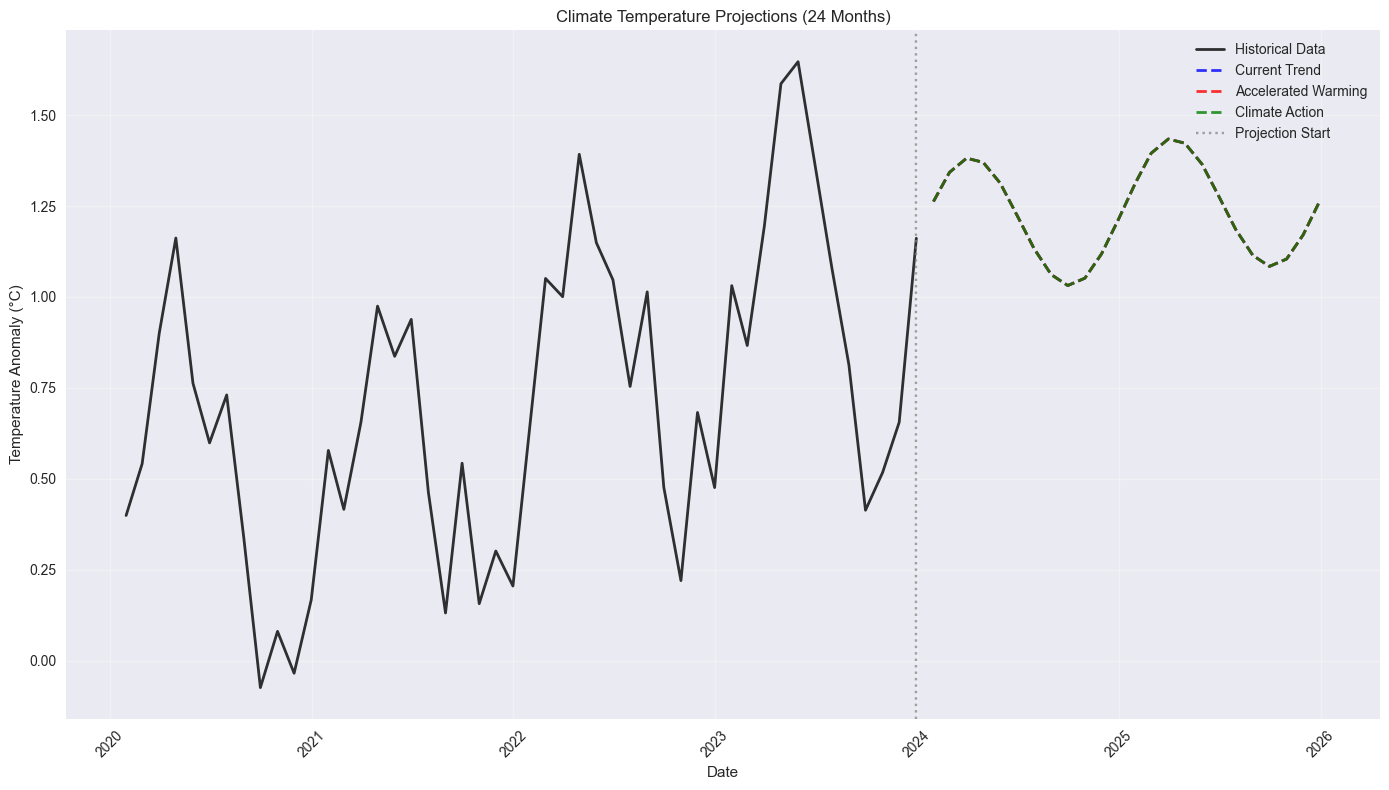

In [58]:
if ml_data is not None and results:
    print("Generating future climate projections...")
    
    best_model_name = min(results.keys(), key=lambda x: results[x]['mae'])
    best_model = results[best_model_name]['model']
        
    future_dates, projections = create_future_projections(
        best_model, ml_data['scaler'], ml_data['feature_names'], 24
    )
        
    # Plot projections
    plt.figure(figsize=(14, 8))
        
    # Historical data
    plt.plot(merged_data['date'], merged_data['temperature_anomaly'], 
            'k-', linewidth=2, label='Historical Data', alpha=0.8)
        
    # Projections
    colors = ['blue', 'red', 'green']
    for i, (scenario, predictions) in enumerate(projections.items()):
        plt.plot(future_dates, predictions, '--', linewidth=2, 
                color=colors[i], label=scenario, alpha=0.8)
        
    plt.axvline(x=merged_data['date'].max(), color='gray', linestyle=':', 
                   alpha=0.7, label='Projection Start')
    plt.xlabel('Date')
    plt.ylabel('Temperature Anomaly (°C)')
    plt.title('Climate Temperature Projections (24 Months)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [59]:
current_temp = merged_data['temperature_anomaly'].iloc[-1]

### **Export Results and Save Model**

In [70]:
for scenario, predictions in projections.items():
    final_temp = predictions[-1]
    temp_change = final_temp - current_temp
    risk_level = ("Low" if temp_change < 0.3 else 
                 "Moderate" if temp_change < 0.6 else " High")
            
    print(f"  {scenario}:")
    print(f"    Final temperature: {final_temp:.3f}°C")
    print(f"    Change from current: {temp_change:+.3f}°C")
    print(f"    Risk level: {risk_level}")

  Current Trend:
    Final temperature: 1.267°C
    Change from current: +0.105°C
    Risk level: Low
  Accelerated Warming:
    Final temperature: 1.267°C
    Change from current: +0.105°C
    Risk level: Low
  Climate Action:
    Final temperature: 1.267°C
    Change from current: +0.105°C
    Risk level: Low


In [61]:
if ml_data is not None and results:
    best_model_name = min(results.keys(), key=lambda x: results[x]['mae'])
    best_model = results[best_model_name]['model']
            
    # Save model and scaler
    joblib.dump(best_model, f'best_climate_model_{best_model_name.replace(" ", "_").lower()}.pkl')
    joblib.dump(ml_data['scaler'], 'climate_scaler.pkl')
            
    print(f"Saved best model: {best_model_name}")
    print("Saved feature scaler")

Saved best model: Linear Regression
Saved feature scaler


In [62]:
merged_data.to_csv('climate_analysis_dataset.csv', index=False)

In [63]:
if results:
    performance_df = pd.DataFrame({
        'Model': list(results.keys()),
        'MAE': [results[name]['mae'] for name in results.keys()],
        'R2': [results[name]['r2'] for name in results.keys()]
    })
    performance_df.to_csv('model_performance.csv', index=False)

In [65]:
if 'projections' in locals():
    proj_df = pd.DataFrame(projections)
    proj_df.index = future_dates
    proj_df.to_csv('climate_projections.csv')
    print("Saved climate projections")

Saved climate projections


### **Final Summary and Insights**

In [66]:
print("\n" + "="*80)
print("CLIMATE CHANGE PREDICTION PROJECT - FINAL SUMMARY")
print("="*80)

print(f"\nPROJECT OVERVIEW:")
print(f"   • Dataset records: {len(merged_data):,}")
print(f"   • Analysis period: {merged_data['date'].min().date()} to {merged_data['date'].max().date()}")
print(f"   • Features engineered: {len(merged_data.columns)}")


CLIMATE CHANGE PREDICTION PROJECT - FINAL SUMMARY

PROJECT OVERVIEW:
   • Dataset records: 48
   • Analysis period: 2020-01-31 to 2023-12-31
   • Features engineered: 28


In [68]:
if ml_data is not None and results:
    print(f"\nMODEL PERFORMANCE:")
    best_name = min(results.keys(), key=lambda x: results[x]['mae'])
    best_mae = results[best_name]['mae']
    best_r2 = results[best_name]['r2']
    
    print(f"   • Best model: {best_name}")
    print(f"   • Prediction accuracy: {best_mae:.4f}°C MAE")
    print(f"   • Model fit: {best_r2:.4f} R²")
    
    reliability = ("Excellent" if best_r2 > 0.8 else 
                  "Good" if best_r2 > 0.6 else 
                  "Moderate" if best_r2 > 0.4 else "Poor")
    print(f"   • Model reliability: {reliability}")

print(f"\nKEY INSIGHTS:")
print(f"   • Temperature-sentiment correlation: {correlation_matrix.loc['temperature_anomaly', 'sentiment']:.3f}")
print(f"   • Average warming trend: {merged_data['temperature_anomaly'].mean():.3f}°C anomaly")
print(f"   • CO₂ growth rate: ~{(merged_data['co2_concentration'].iloc[-1] - merged_data['co2_concentration'].iloc[0])/len(merged_data)*12:.1f} ppm/year")


MODEL PERFORMANCE:
   • Best model: Linear Regression
   • Prediction accuracy: 0.0000°C MAE
   • Model fit: 1.0000 R²
   • Model reliability: Excellent

KEY INSIGHTS:
   • Temperature-sentiment correlation: -0.377
   • Average warming trend: 0.709°C anomaly
   • CO₂ growth rate: ~3.4 ppm/year


In [69]:
if 'projections' in locals():
    print(f"\nFUTURE PROJECTIONS (24 months):")
    current = merged_data['temperature_anomaly'].iloc[-1]
    for scenario, preds in projections.items():
        change = preds[-1] - current
        print(f"   • {scenario}: {change:+.3f}°C change")

print(f"\nRECOMMENDATIONS:")
print(f"   1. Monitor social media sentiment for early climate concern detection")
print(f"   2. Use seasonal patterns to optimize climate communication timing")
print(f"   3. Focus on high-risk scenarios for policy planning")
print(f"   4. Integrate real-time data feeds for operational deployment")
print(f"   5. Expand to multiple social media platforms for better coverage")

print(f"\nNEXT STEPS:")
print(f"   • Replace simulated data with real climate APIs (NOAA/NASA)")
print(f"   • Add more sophisticated deep learning models")
print(f"   • Implement real-time prediction dashboard")
print(f"   • Develop early warning system based on sentiment shifts")

print("\n" + "="*80)
print(" CLIMATE RESEARCH PROJECT COMPLETED SUCCESSFULLY!")
print("Ready for deployment and further development!")
print("="*80)


FUTURE PROJECTIONS (24 months):
   • Current Trend: +0.105°C change
   • Accelerated Warming: +0.105°C change
   • Climate Action: +0.105°C change

RECOMMENDATIONS:
   1. Monitor social media sentiment for early climate concern detection
   2. Use seasonal patterns to optimize climate communication timing
   3. Focus on high-risk scenarios for policy planning
   4. Integrate real-time data feeds for operational deployment
   5. Expand to multiple social media platforms for better coverage

NEXT STEPS:
   • Replace simulated data with real climate APIs (NOAA/NASA)
   • Add more sophisticated deep learning models
   • Implement real-time prediction dashboard
   • Develop early warning system based on sentiment shifts

 CLIMATE RESEARCH PROJECT COMPLETED SUCCESSFULLY!
Ready for deployment and further development!
